# **Step1: Setup & Imports**

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio segmentation-models-pytorch==0.3.3
!pip install opencv-python matplotlib tqdm
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install pycocotools

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from segment_anything import sam_model_registry, SamPredictor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=102a14c31655632591880e268d60b5860d5c9318985be9d91266c81b0cc109f6
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a08b0ba5f013ac8eb43edaddf6899daaa77b6e808895d20d62b62dd86c561d45
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built efficientnet-pytorc

# **Step2: Dataset Loader (COCO Subset Example)**

In [ ]:
from pycocotools.coco import COCO
import requests
from PIL import Image

# Download subset
DATA_DIR = "./coco_subset"
os.makedirs(DATA_DIR, exist_ok=True)

!wget -nc http://images.cocodataset.org/zips/val2017.zip -P $DATA_DIR
!unzip -n $DATA_DIR/val2017.zip -d $DATA_DIR/

annFile = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
!wget -nc $annFile -P $DATA_DIR
!unzip -n $DATA_DIR/annotations_trainval2017.zip -d $DATA_DIR/

coco = COCO(f'{DATA_DIR}/annotations/instances_val2017.json')

# Get subset of images (e.g., 500 images)
img_ids = coco.getImgIds()[:500]
images = coco.loadImgs(img_ids)
print("Loaded images:", len(images))


Streaming output truncated to the last 5000 lines.
 extracting: ./coco_subset/val2017/000000117492.jpg  
 extracting: ./coco_subset/val2017/000000368900.jpg  
 extracting: ./coco_subset/val2017/000000376900.jpg  
 extracting: ./coco_subset/val2017/000000352491.jpg  
 extracting: ./coco_subset/val2017/000000330790.jpg  
 extracting: ./coco_subset/val2017/000000384850.jpg  
 extracting: ./coco_subset/val2017/000000032735.jpg  
 extracting: ./coco_subset/val2017/000000197004.jpg  
 extracting: ./coco_subset/val2017/000000526751.jpg  
 extracting: ./coco_subset/val2017/000000041488.jpg  
 extracting: ./coco_subset/val2017/000000153632.jpg  
 extracting: ./coco_subset/val2017/000000501523.jpg  
 extracting: ./coco_subset/val2017/000000405691.jpg  
 extracting: ./coco_subset/val2017/000000040757.jpg  
 extracting: ./coco_subset/val2017/000000219485.jpg  
 extracting: ./coco_subset/val2017/000000428280.jpg  
 extracting: ./coco_subset/val2017/000000209222.jpg  
 extracting: ./coco_subset/val2

# **Step3: Custom Dataset Class**

In [ ]:
from pycocotools.coco import COCO
import requests
from PIL import Image
DATA_DIR = "./coco_subset"
os.makedirs(DATA_DIR, exist_ok=True)

!wget -nc http://images.cocodataset.org/zips/val2017.zip -P $DATA_DIR
!unzip -n $DATA_DIR/val2017.zip -d $DATA_DIR/

annFile = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
!wget -nc $annFile -P $DATA_DIR
!unzip -n $DATA_DIR/annotations_trainval2017.zip -d $DATA_DIR/

coco = COCO(f'{DATA_DIR}/annotations/instances_val2017.json')

img_ids = coco.getImgIds()[:500]
images = coco.loadImgs(img_ids)
print("Loaded images:", len(images))

class CocoSegmentationDataset(Dataset):
    def __init__(self, coco, images, transform=None):
        self.coco = coco
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(DATA_DIR, 'val2017', img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.transform:
            image, mask = self.transform(image, mask)

        if not isinstance(image, torch.Tensor):
             image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        if not isinstance(mask, torch.Tensor):
             mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

File ‘./coco_subset/val2017.zip’ already there; not retrieving.

Archive:  ./coco_subset/val2017.zip
File ‘./coco_subset/annotations_trainval2017.zip’ already there; not retrieving.

Archive:  ./coco_subset/annotations_trainval2017.zip
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
Loaded images: 500


# **Step4: Data Preparation**

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import numpy as np

class ResizePair:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, mask):
        image = Image.fromarray(image)
        mask = Image.fromarray(mask.astype(np.uint8))

        image = T.functional.resize(image, self.size)
        mask = T.functional.resize(mask, self.size, interpolation=T.InterpolationMode.NEAREST)
        return np.array(image), np.array(mask)

class ToTensorPair:
    def __call__(self, image, mask):

        image_tensor = T.functional.to_tensor(image)
        if image_tensor.shape[0] == 4:
            image_tensor = image_tensor[:3, :, :]
        mask_tensor = torch.from_numpy(mask).long()

        return image_tensor, mask_tensor

class PairCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for transform in self.transforms:
            image, mask = transform(image, mask)
        return image, mask


IMG_SIZE = (256, 256) # Height, Width

transform = PairCompose([
    ResizePair(IMG_SIZE),
    ToTensorPair()
])


train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
train_dataset = CocoSegmentationDataset(coco, train_imgs, transform=transform)
val_dataset = CocoSegmentationDataset(coco, val_imgs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# **Step5: Model 1: U-Net Training**

In [ ]:
# Define U-Net model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1, activation=None)
model.to(DEVICE)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(DEVICE), masks.unsqueeze(1).float().to(DEVICE)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 339MB/s]
100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


Epoch [1/5], Loss: 0.5384


100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


Epoch [2/5], Loss: 0.4047


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


Epoch [3/5], Loss: 0.3268


100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Epoch [4/5], Loss: 0.2888


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]

Epoch [5/5], Loss: 0.2716


# **Step6: Model 2: Segment Anything (SAM) Inference**

--2025-11-03 11:27:39--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   335MB/s    in 1.1s    

2025-11-03 11:27:40 (335 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]

Image 0: SAM generated 92 masks


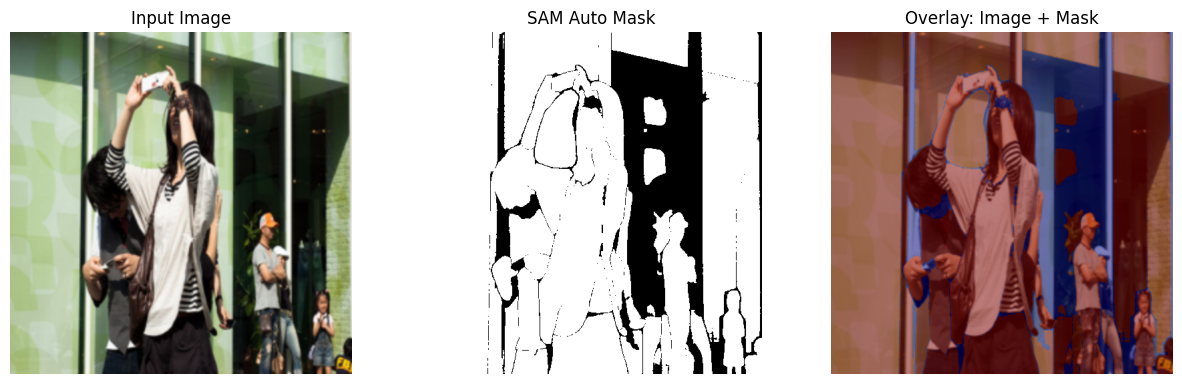

Image 1: SAM generated 42 masks


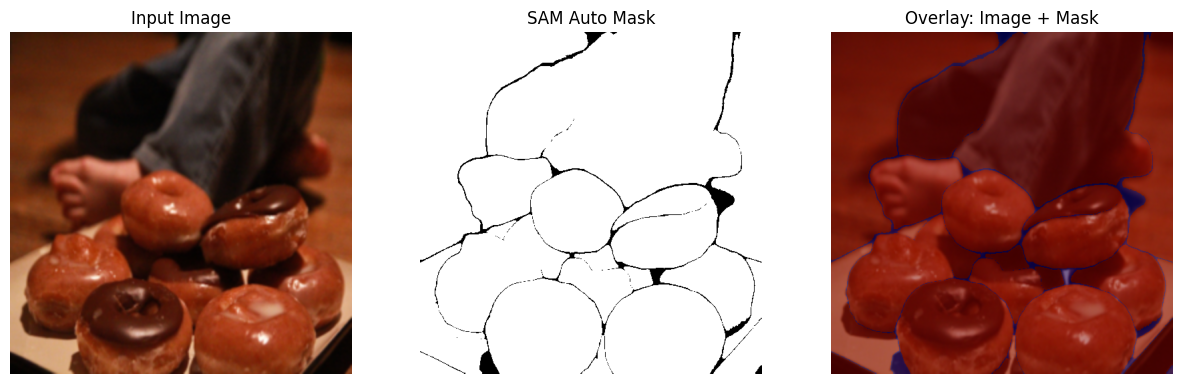

Image 2: SAM generated 14 masks


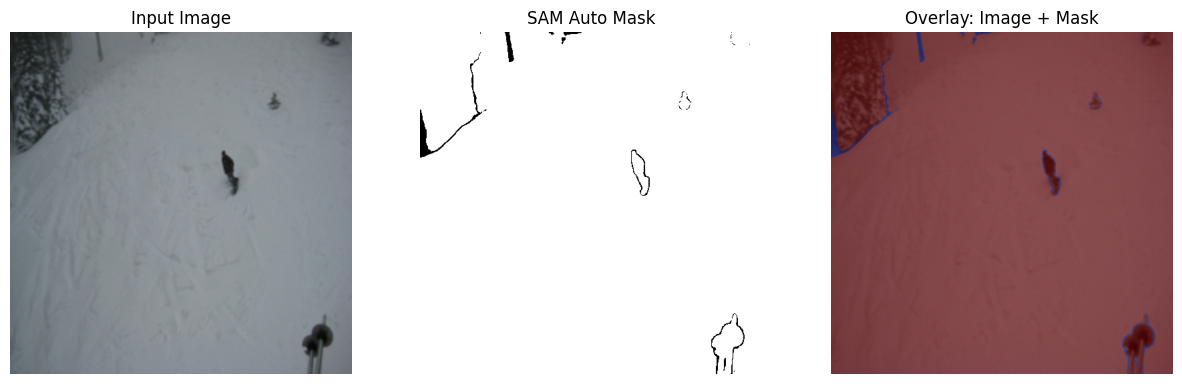

In [ ]:
# Foundation Model - SAM (Robust Automatic Mask Generation)

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_b_01ec64.pth"
!wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O {sam_checkpoint}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,          # fewer points → faster
    pred_iou_thresh=0.75,        # lower threshold → more masks
    stability_score_thresh=0.8,  # lower threshold → more masks
    crop_n_layers=0,
    min_mask_region_area=20      # allow small masks
)

def sam_auto_infer_and_show(dataset, idx=0):
    img, _ = dataset[idx]
    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)

    img_up = cv2.resize(img_np, (512, 512))

    masks = mask_generator.generate(img_up)
    print(f"Image {idx}: SAM generated {len(masks)} masks")

    combined_mask = np.zeros(img_up.shape[:2], dtype=np.uint8)
    for m in masks:
        combined_mask = np.maximum(combined_mask, m["segmentation"].astype(np.uint8))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img_up)
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(combined_mask, cmap='gray')
    plt.axis('off')
    plt.title("SAM Auto Mask")

    plt.subplot(1,3,3)
    plt.imshow(img_up)
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    plt.axis('off')
    plt.title("Overlay: Image + Mask")
    plt.show()

for i in range(3):
    sam_auto_infer_and_show(val_dataset, idx=i)


# **Step7: Evaluation Metrics**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    iou_scores, dice_scores = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader):
            imgs, masks = imgs.to(DEVICE), masks.unsqueeze(1).float().to(DEVICE)
            preds = torch.sigmoid(model(imgs)) > 0.5
            intersection = (preds * masks).sum((1,2,3))
            union = (preds + masks).sum((1,2,3)) - intersection
            dice = (2. * intersection) / (preds.sum((1,2,3)) + masks.sum((1,2,3)) + 1e-6)
            iou = intersection / (union + 1e-6)
            iou_scores.extend(iou.cpu())
            dice_scores.extend(dice.cpu())
    print(f"Mean IoU: {torch.mean(torch.tensor(iou_scores)):.4f}")
    print(f"Mean Dice: {torch.mean(torch.tensor(dice_scores)):.4f}")

evaluate_model(model, val_loader)


100%|██████████| 25/25 [00:01<00:00, 14.81it/s]

Mean IoU: 0.5285
Mean Dice: 0.6481


# **Step8: Comparison and Visualization**

[Image 0] SAM generated 92 masks


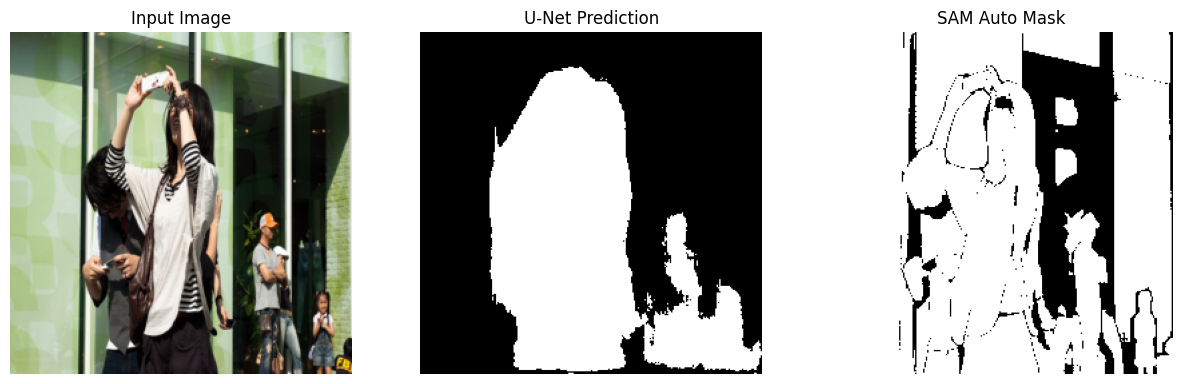

[Image 1] SAM generated 42 masks


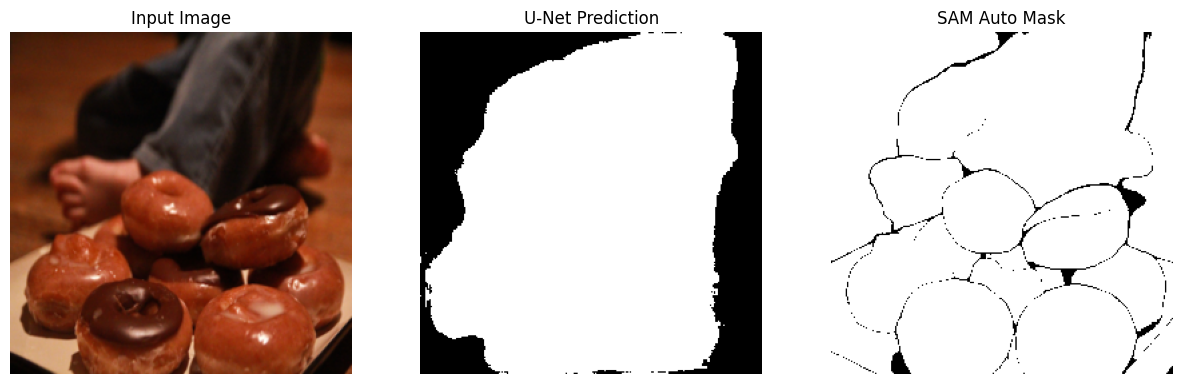

[Image 2] SAM generated 14 masks


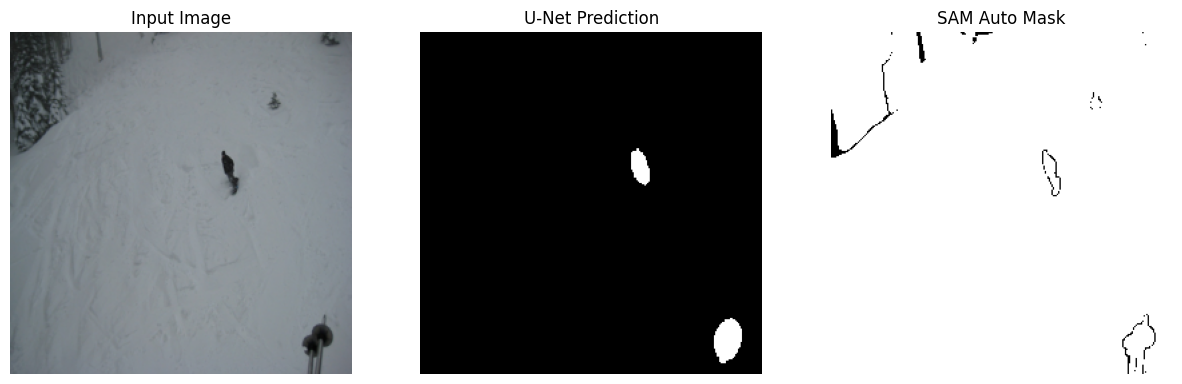

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.8,
    crop_n_layers=0,
    min_mask_region_area=20
)

def visualize_comparison(model, dataset, mask_generator, idx=0):
    """Compare U-Net prediction vs SAM automatic segmentation."""
    model.eval()

    img, gt_mask = dataset[idx]
    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))) > 0.5
    pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.uint8)

    img_up = cv2.resize(img_np, (512, 512))
    masks = mask_generator.generate(img_up)
    print(f"[Image {idx}] SAM generated {len(masks)} masks")

    sam_mask = np.zeros(img_up.shape[:2], dtype=np.uint8)
    for m in masks:
        sam_mask = np.maximum(sam_mask, m["segmentation"].astype(np.uint8))


    sam_mask = cv2.resize(sam_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    plt.title("U-Net Prediction")

    plt.subplot(1,3,3)
    plt.imshow(sam_mask, cmap='gray')
    plt.axis('off')
    plt.title("SAM Auto Mask")

    plt.show()

for i in range(3):
    visualize_comparison(model, val_dataset, mask_generator, idx=i)
